# Analysis


In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

/home/frabatx/.local/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# il csv totalProcessed contiene address non ancora elaborati
# il csv toAnalize ha tutti i dati completi, mancano solo i quartieri

df = pd.read_csv('data/toAnalyse.csv')
df

,address,day,keywords,latitude,link,list_keywords,location,longitude,month,point,subtitle,text,timestamp,title,year
0,"Trento,Piazza del Duomo",8,"['strade', 'trasporti', 'viabilità']",46.067647,https://www.trentotoday.it/attualita/strada-bo...,"['Strade', 'Trasporti', 'Viabilità']","""Piazza del Duomo, Centro storico Trento, Tren...",11.121092,11,"['11.1210924', ' 46.0676474']",La strada sarà chiusa durante le operazioni di...,strada chiusa trasporto alberi natale comune ...,2020/11/08,Arrivano gli alberi di Natale: chiusa la strad...,2020
1,"Trento,Via Fersina",8,"['alpini', 'esercito', 'tamponi']",46.057797,https://www.trentotoday.it/attualita/esercito-...,"['Alpini', 'Esercito', 'Tamponi']","""Via Fersina, Man Malpensada, Clarina, Trento,...",11.132759,11,"['11.13275943562951', ' 46.057797050000005']",Operazione del Ministero della Difesa in suppo...,arriva trento punto tamponi gestito dall eser...,2020/11/08,Tamponi: anche a Trento arriva l'esercito,2020
2,"Trento,Largo Medaglie d'oro",7,"['bollettino', 'contagi', 'coronavirus']",46.057797,https://www.trentotoday.it/cronaca/bollettino-...,"['Bollettino', 'Contagi', 'Coronavirus']","""Largo Medaglie d'Oro, Man Malpensada, Bolgher...",11.132759,11,"['11.13275943562951', ' 46.057797050000005']",Non accenna a diminuire il contagio: ecco i da...,accenna appiattirsi linea contagi trentino 25...,2020/11/07,Bollettino coronavirus: 251 nuovi casi in Tren...,2020
3,"Dro,Via Monte Casale",7,"['incidenti montagna', 'morti', 'morti in mont...",46.031499,https://www.trentotoday.it/cronaca/federica-ma...,"['Incidenti', 'Montagna', 'Morti', 'Morti', 'I...","""Monte Casale, Via Ferrata Ernesto Che Guevara...",10.927659,11,"['10.9276592', ' 46.031499']","Tragico incidente sulla ""Che Guevara"", probabi...","federica marcolla, medico mamma bambini, la v...",2020/11/07,"Precipita in ferrata: morta Federica Marcolla,...",2020
4,"Dro,Via Monte Casale",7,"['ferrate', 'incidenti montagna', 'morti']",46.031499,https://www.trentotoday.it/cronaca/ragazza-mor...,"['Ferrate', 'Incidenti', 'Montagna', 'Morti']","""Monte Casale, Via Ferrata Ernesto Che Guevara...",10.927659,11,"['10.9276592', ' 46.031499']","Drammatico incidente alla ferrata Che Guevara,...",mattinata drammatica monte casale ragazza 32 ...,2020/11/07,"Dro, precipita dalla ferrata per 200 metri e m...",2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28676,NaN,9,['lavoro'],0.000000,http://www.trentotoday.it/economia/progettone-...,['Lavoro'],NaN,0.000000,11,"[0.0, 0.0]",I sindacati non hanno raggiunto l'intesa con l...,nan,2011/11/09,Progettone: niente accordo sugli stipendi dei ...,2011
28677,NaN,9,['tecnologie'],0.000000,http://www.trentotoday.it/cronaca/internet-con...,['Tecnologie'],NaN,0.000000,11,"[0.0, 0.0]",Presenti a Trento oltre cento relatori per dis...,nan,2011/11/09,Le nuove frontiere di internet: due giorni di ...,2011
28678,NaN,9,['religione'],0.000000,http://www.trentotoday.it/cronaca/moschea-gard...,['Religione'],NaN,0.000000,11,"[0.0, 0.0]",La comunità musulmana trentina potrà utilizzar...,gardolo centro islamico consiglio stato infat...,2011/11/09,Centro islamico a Gardolo: il Consiglio di Sta...,2011
28679,NaN,9,['trasporti'],0.000000,http://www.trentotoday.it/cronaca/piedibus-mea...,['Trasporti'],NaN,0.000000,11,"[0.0, 0.0]","Hanno già aderito trentasei bambini, suddivisi...",grazie disponibilità sedici genitori volontar...,2011/11/09,Piedibus: il servizio gratuito arriva anche a ...,2011


# Address 
Alcune degli address Nan sono stati interpretati male e hanno prodotto una location fittizia: Nanno. Vado a modificare questa cosa azzerando sia location sia point, latitude, longitude

Controllo gli indirizzi che non sono stati convertiti. Questi indirizzi sono quelli che hanno la colonna "address" ma non hanno "location".

Tra i dati totali sono geolocalizzabili 22.536 elementi su un totale di 28.681. Di questi 22.536, 4695 sono da rivedere poiché la divisione geografica é riferita ai quartieri. Vediamo se riesco a ricavarne qualcosa.
Esempio sono:
* Oltrefersina -> Riferito al quartiere di trento e non ad una cittá  1619 rows
* Argentario -> 72 Rows
* Rimuovere la parola localitá
* Bondone, 79 rows
* San Giuseppe, 1191 rows
* Gardolo, 203 rows.

Let's change it

Arrivati a questo punto la pulizia degli address é completata ed é possibile rimappare i punti non geocodificati in precedenza

# Inserisco i quartieri
Considero un altro dataset preso da trentino opendata polisociali.zip che contiene al suo interno la forma di ogni quartiere di trento, al fine di migliorare la qualitá delle informazioni che ho al mio dataset, cerco di identificare in quale quartiere é stata creata una determinata notizia, in modo da poter fare una analisi geografica.

In [23]:
from shapely import wkt
import geopandas as gpd
#df_quartieri = pd.read_csv('data/poli_sociali.csv', delimiter=';')
#df_quartieri = geopandas.read_file('data/poli_sociali.csv')
# loading polygons geodataframe
gdf_polygons = gpd.read_file('data/poli_sociali/poli_sociali.shp')
gdf_points = gpd.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [51]:
#df_quartieri['WKT'] = df_quartieri['WKT'].apply(wkt.loads)
gdf_polygons
#gdf_points.head()

,area,cod_quart,nome_quart,cod_polo,fumetto,perimetro,nome_polo,sigla,simbolo_at,simbolo2-a,geometry
0,244180,21,SAN PIO X,3,Quartiere SAN PIO X nel polo sociale S.GIUSEPP...,2404,S.GIUSEPPE-S.CHIARA E RAVINA-ROMAGNANO,TN 3,NaN,5.0,"POLYGON ((11.12470 46.05642, 11.12342 46.05513..."
1,1517895,6,CAMPOTRENTINO,2,Quartiere CAMPOTRENTINO nel polo sociale CENTR...,5807,"CENTRO STORICO, PIEDICASTELLO, BONDONE E SARDAGNA",TN 6,NaN,5.0,"POLYGON ((11.10914 46.09449, 11.11107 46.09216..."
2,550103,28,SAN BARTOLOMEO,4,Quartiere SAN BARTOLOMEO nel polo sociale OLTR...,4403,OLTREFERSINA E MATTARELLO,TN 4,44.0,NaN,"POLYGON ((11.13564 46.05095, 11.13600 46.05090..."
3,7356368,31,VILLAZZANO,5,Quartiere VILLAZZANO nel polo sociale ARGENTAR...,15014,"ARGENTARIO, POVO E VILLAZZANO",TN 1,12.0,NaN,"POLYGON ((11.13953 46.05711, 11.13960 46.05710..."
4,1969068,27,CLARINA,4,Quartiere CLARINA nel polo sociale OLTREFERSIN...,7958,OLTREFERSINA E MATTARELLO,TN 4,4.0,NaN,"POLYGON ((11.12193 46.05330, 11.12295 46.05406..."
5,365695,8,MELTA,1,Quartiere MELTA nel polo sociale GARDOLO E MEANO,2869,GARDOLO E MEANO,TN 7,6.0,7.0,"POLYGON ((11.12026 46.10294, 11.12127 46.10168..."
6,565515,10,CANOVA,1,Quartiere CANOVA nel polo sociale GARDOLO E MEANO,3584,GARDOLO E MEANO,TN 7,6.0,7.0,"POLYGON ((11.10187 46.10326, 11.10216 46.10330..."
7,1101422,4,SOLTERI-CENTOCHIAVI,2,Quartiere SOLTERI-CENTOCHIAVI nel polo sociale...,4689,"CENTRO STORICO, PIEDICASTELLO, BONDONE E SARDAGNA",TN 5,6.0,5.0,"POLYGON ((11.12180 46.09473, 11.12190 46.09422..."
8,143676,34,SAN DONA'-LASTE,5,Quartiere SAN DONA'-LASTE nel polo sociale ARG...,2598,"ARGENTARIO, POVO E VILLAZZANO",TN 2,12.0,NaN,"POLYGON ((11.12512 46.08588, 11.12515 46.08557..."
9,2765516,12,SPINI-GHIAIE,1,Quartiere SPINI-GHIAIE nel polo sociale GARDOL...,7806,GARDOLO E MEANO,TN 7,6.0,7.0,"POLYGON ((11.08397 46.12546, 11.08400 46.12548..."


In [28]:
gdf_points.crs

In [35]:
gdf_polygons.to_crs("EPSG:4326", inplace=True)

Dai risultati emersi sono geolocalizzabili 18.617 elementi. Di questi voglio sapere i quartieri. Per fare questo devo trasformare il mio dataframe in geodataframe. In questo modo avró i miei punti formati.
Fatto questo per ogni punto devo interrogare l'altro dataframe per vedere in che quartiere é, assegnargli poi il quartiere. Devo fare bene questa fase perché devo ancora capire quale informazione devo riportare nel mio df.
Per il momento scelgo di inserire una colonna Nome_Quartiere id_quartiere

In [72]:
dfplus = geopandas.sjoin(gdf_points, gdf_polygons, how="left", op='within')
dfplus.columns

Index(['address', 'day', 'keywords', 'latitude', 'link', 'list_keywords',
       'location', 'longitude', 'month', 'point', 'subtitle', 'text',
       'timestamp', 'title', 'year', 'geometry', 'index_right', 'area',
       'cod_quart', 'nome_quart', 'cod_polo', 'fumetto', 'perimetro',
       'nome_polo', 'sigla', 'simbolo_at', 'simbolo2-a'],
      dtype='object')

<AxesSubplot:>

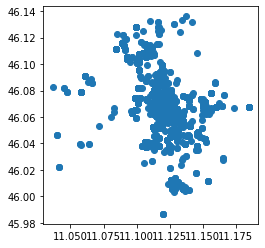

In [57]:
#dfplus[(dfplus['area'].notnull())].plot()
#gdf_polygons[gdf_polygons['nome_quart'] == 'CENTRO STORICO'].plot(figsize=(20,20))

Prossimo passo é inserire nel dataset l'informazione sulla città. Farò quello che ho fatto con i quartieri per tutto il trentino. In questo modo avró una informazione completa su ogni punto. Il dataset che utilizzo é quello dell'istat 

In [61]:
import fiona
fiona.listlayers('data/istat_administrative_units_2020.gpkg')

['municipalities', 'provincies', 'regions', 'macroregions']

In [64]:
municipalities = gpd.read_file("data/istat_administrative_units_2020.gpkg",layer="municipalities")


In [68]:
# filter the province
municipalities_province_trento = municipalities[municipalities.COD_PROV==22]
municipalities_province_trento.to_crs("EPSG:4326", inplace=True)

In [73]:
municipalities_province_trento.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM',
       'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_UTS', 'geometry'],
      dtype='object')

In [76]:
gdfPlus = gpd.GeoDataFrame(
    dfplus, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
gdfPlus = gdfPlus.drop(['index_right'], axis=1)

In [77]:
dfComplete = geopandas.sjoin(gdfPlus, municipalities_province_trento, how="left", op='within')

In [82]:
dfComplete[dfComplete['COMUNE'].notnull()].columns

Index(['address', 'day', 'keywords', 'latitude', 'link', 'list_keywords',
       'location', 'longitude', 'month', 'point', 'subtitle', 'text',
       'timestamp', 'title', 'year', 'geometry', 'area', 'cod_quart',
       'nome_quart', 'cod_polo', 'fumetto', 'perimetro', 'nome_polo', 'sigla',
       'simbolo_at', 'simbolo2-a', 'index_right', 'COD_RIP', 'COD_REG',
       'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM', 'PRO_COM_T', 'COMUNE',
       'COMUNE_A', 'CC_UTS'],
      dtype='object')

In [85]:
cols = ['timestamp', 'day', 'month', 'year', 'list_keywords','title','subtitle','text',
        'address','location','geometry','latitude','longitude',
        'cod_quart','nome_quart','COD_CM','COMUNE']
dfComplete = dfComplete[cols]

In [87]:
dfComplete.rename(columns=str.lower, inplace=True)
dfComplete.to_csv('data/complete.csv', index=False)